In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
from statistics import mean, stdev

In [3]:
import keras_tuner as kt
import MVA as ga
from keras_tuner import RandomSearch

In [4]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=0, parse_dates=[8])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [8]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 7              # No of loop detectors
n_seq = 3                    # Subsequences
n_steps = 5                  # time-step per subsequence
val_percent = 0.12962        # 2 weeks
batch_size = 32

#### 5 mins

In [9]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = Output_train_5

In [10]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = Output_test_5

#### 15 mins

In [11]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = Output_train_15

In [12]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = Output_test_15

#### 30 mins

In [13]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = Output_train_30

In [14]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = Output_test_30

#### 60 mins

In [15]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = Output_train_60

In [16]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = Output_test_60

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [17]:
# define no_of_channels
n_channels = 1

In [18]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [19]:
Xv5.shape

(4017, 3, 5, 7, 1)

# CNN-LSTM model

In [20]:
from tensorflow import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [21]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

# 5 mins ahead

In [22]:
model5 = keras.models.load_model("my_dir/7b-CNN-LSTM-5") 

### Evaluation on inverse_transform

In [23]:
test_predictions5 = model5.predict((Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,4]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,4]

# MSE5 = mean_squared_error(yv5,test_predictions5)

# MAE5 = mean_absolute_error(yv5,test_predictions5)

# RMSE5 = np.sqrt(MSE5)

# MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

# eval5 = [MSE5, MAE5, RMSE5, MAPE5]
# print(eval5)

In [24]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[70.12696041822255, 85.21284540702017, 93.10430669653971]


In [25]:
GEH, num, _, _ = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [26]:
x = np.arange(1,len(GEH)+1)

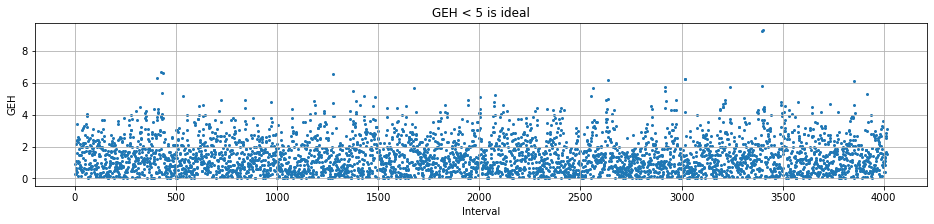

In [27]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [28]:
GEH5 = num/len(GEH)

# 15 mins ahead

In [29]:
model15 = keras.models.load_model("my_dir/7b-CNN-LSTM-15")

### Evaluation on inverse_transform

In [30]:
test_predictions15 = model15.predict(Xv15)

yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv15 = yv15[17:,4]

df = Test.drop(Test.head(17).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions15.flatten())

test_predictions15 = scaler.inverse_transform(df)

test_predictions15 = test_predictions15[:,4]

# MSE15 = mean_squared_error(yv15,test_predictions15)

# MAE15 = mean_absolute_error(yv15,test_predictions15)

# RMSE15 = np.sqrt(MSE15)

# MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

# eval15 = [MSE15, MAE15, RMSE15, MAPE15]
# print(eval15)

In [31]:
RA10 = ra.RA_10(np.asarray(yv15), np.asarray(test_predictions15))
RA15 = ra.RA_15(np.asarray(yv15), np.asarray(test_predictions15))
RA20 = ra.RA_20(np.asarray(yv15), np.asarray(test_predictions15))

res15 = [RA10, RA15, RA20]
print(res15)

[61.96762141967621, 79.37733499377335, 89.04109589041096]


In [32]:
GEH, num, _, _ = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))

In [33]:
x = np.arange(1,len(GEH)+1)

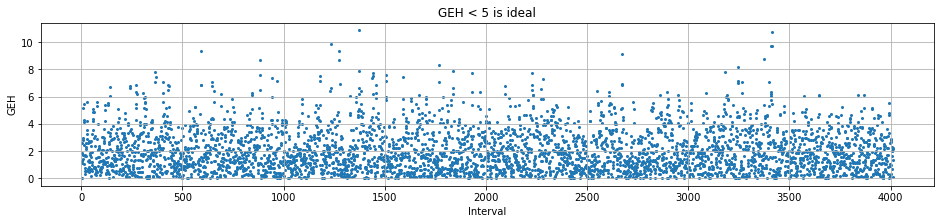

In [34]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [35]:
GEH15 = num/len(GEH)

# 30 mins ahead

In [36]:
model30 = keras.models.load_model("my_dir/7b-CNN-LSTM-30")

### Evaluation on inverse_transform

In [37]:
test_predictions30 = model30.predict(Xv30)

yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv30 = yv30[20:,4]

df = Test.drop(Test.head(20).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions30.flatten())

test_predictions30 = scaler.inverse_transform(df)

test_predictions30 = test_predictions30[:,4]

# MSE30 = mean_squared_error(yv30,test_predictions30)

# MAE30 = mean_absolute_error(yv30,test_predictions30)

# RMSE30 = np.sqrt(MSE30)

# MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

# eval30 = [MSE30, MAE30, RMSE30, MAPE30]
# print(eval30)

In [38]:
RA10 = ra.RA_10(np.asarray(yv30), np.asarray(test_predictions30))
RA15 = ra.RA_15(np.asarray(yv30), np.asarray(test_predictions30))
RA20 = ra.RA_20(np.asarray(yv30), np.asarray(test_predictions30))

res30 = [RA10, RA15, RA20]
print(res30)

[59.97008973080757, 76.09670987038884, 85.89232303090728]


In [39]:
GEH, num, _, _ = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))

In [40]:
x = np.arange(1,len(GEH)+1)

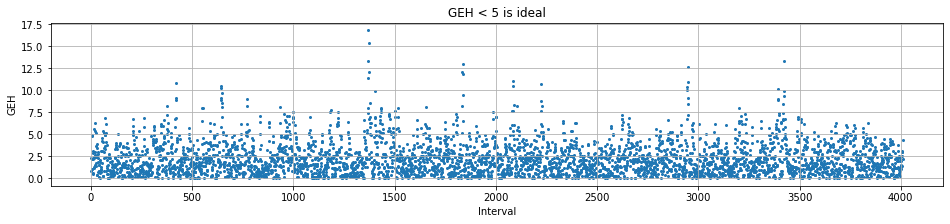

In [41]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [42]:
GEH30 = num/len(GEH)

# 60 mins ahead

In [43]:
model60 = keras.models.load_model("my_dir/7b-CNN-LSTM-60")

### Evaluation on inverse_transform

In [44]:
test_predictions60 = model60.predict((Xv60))

yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv60 = yv60[26:,4]

df = Test.drop(Test.head(26).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions60.flatten())

test_predictions60 = scaler.inverse_transform(df)

test_predictions60 = test_predictions60[:,4]

# MSE60 = mean_squared_error(yv60,test_predictions60)

# MAE60 = mean_absolute_error(yv60,test_predictions60)

# RMSE60 = np.sqrt(MSE60)

# MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

# eval60 = [MSE60, MAE60, RMSE60, MAPE60]
# print(eval60)

In [45]:
RA10 = ra.RA_10(np.asarray(yv60), np.asarray(test_predictions60))
RA15 = ra.RA_15(np.asarray(yv60), np.asarray(test_predictions60))
RA20 = ra.RA_20(np.asarray(yv60), np.asarray(test_predictions60))

res60 = [RA10, RA15, RA20]
print(res60)

[56.44033949076386, 73.5646530204693, 84.12381427858213]


In [46]:
GEH, num, _, _ = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))

In [47]:
x = np.arange(1,len(GEH)+1)

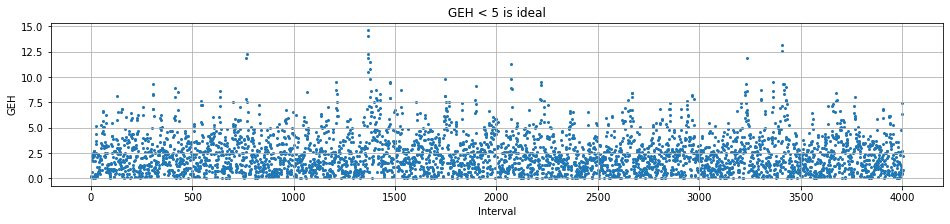

In [48]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [49]:
GEH60 = num/len(GEH)

## GEH

In [ ]:
m = ["GEH5", "GEH15", "GEH30", "GEH60"]

In [ ]:
GEH = [GEH5, GEH15, GEH30, GEH60]

In [ ]:
data = np.asarray(GEH).reshape((1, 4))
df = pd.DataFrame(data=data,columns=m)
df